# Introduction

This notebook contains a few examples of how SCINS can be used (method described in the appendix this paper: https://pubs.acs.org/doi/10.1021/ci6004004). To a large extent I have followed Greg Landrum's recent blog post on the problems with scaffold splits: https://greglandrum.github.io/rdkit-blog/posts/2024-05-31-scaffold-splits-and-murcko-scaffolds1. Mainly, I would like to briefly show some examples of how to apply SCINS in order to get it to work for your dataset, but also address something from the blog post - one of the major takeaways was that Murcko scaffolds are often too fine-grained to work well as a representation based on which train-test splitting can be done.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import rdkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AtomValenceException, Draw
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol, MakeScaffoldGeneric

from scins import scins

print("RDKit v: ", rdkit.__version__)

rdl = RDLogger.logger()
rdl.setLevel(RDLogger.CRITICAL)

pd.options.display.max_columns=None
pd.options.display.max_colwidth=None

Matplotlib is building the font cache; this may take a moment.
/var/folders/xm/ht_73jb97b5gk0nqhsyggc640000gn/T/ipykernel_31882/3331492489.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


RDKit v:  2023.09.3


## Data

Use Greg's ChEMBL queries. I am connecting to a local copy of ChEMBL v33 downloaded from here: https://chembl.gitbook.io/chembl-interface-documentation/downloads

In [2]:
HYPERVALENT_DUMMY = "HYPERVALENT"
NONE_DUMMY = "NONE"
ERROR_DUMMY = "ERROR"

def get_scaffold_for_smi(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return NONE_DUMMY
    except:
        return NONE_DUMMY
    try:
        scaffold = GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold, canonical=True)
    except Exception as e:
        print(e)
        return ERROR_DUMMY

def get_gen_scaffold_for_smi_with_sp2(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return NONE_DUMMY
    except:
        return NONE_DUMMY
    try:
        scaffold = GetScaffoldForMol(mol)
        generic_scaffold = MakeScaffoldGeneric(scaffold)
        return Chem.MolToSmiles(generic_scaffold, canonical=True)
    except AtomValenceException:
        return HYPERVALENT_DUMMY

def get_gen_scaffold_for_smi_without_sp2(smi):
    try:
        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            return NONE_DUMMY
    except:
        return NONE_DUMMY
    try:
        scaffold = scins.GetScaffoldForMol_edited(mol)
        generic_scaffold = MakeScaffoldGeneric(scaffold)
        
        # the following two lines can substitute the previous two
        # but beware atoms with valence > 4 (look out for scins.ERROR_SCINS later)
        # generic_mol = MakeScaffoldGeneric(mol)
        # generic_scaffold = GetScaffoldForMol(generic_mol)
        
        return Chem.MolToSmiles(generic_scaffold, canonical=True)
    except AtomValenceException:
        return HYPERVALENT_DUMMY

def get_scins_for_gen_scaffold_smi(smi):
    return scins.generic_scaffold_smiles_to_scins(smi)

In [3]:
con = sqlite3.connect("/Users/kamen/Downloads/chembl_34/chembl_34_sqlite/chembl_34.db")

In [4]:
query = """
WITH assay_counts AS (
                    select assays.chembl_id,
                           activities.assay_id,
                           count(distinct molregno) cnt
                    from assays 
                    join activities 
                           on assays.assay_id=activities.assay_id
                    join docs 
                           on (assays.doc_id = docs.doc_id)
                    where (standard_type='Ki' and
                           assays.doc_id is not null and
                           doi is not null and
                           year is not null)
                    group by assays.chembl_id, assays.assay_id
)
select * from assay_counts where cnt>20 and cnt<100
"""

In [5]:
df_all_assays = pd.read_sql(query, con)

In [6]:
df_all_assays.shape

(7186, 3)

Greg reported 7148 but it's close enough and the logic is the same so fine

In [7]:
df_all_assays.head(2)

,chembl_id,assay_id,cnt
0,CHEMBL1000139,496150,30
1,CHEMBL1000140,496151,28


Example assay from the blog post:

In [8]:
aid = 'CHEMBL1803423'

In [9]:
query_aid = """
select distinct(canonical_smiles), cids.chembl_id
    from activities 
        join assays on activities.assay_id=assays.assay_id
        join compound_structures on compound_structures.molregno=activities.molregno
        join chembl_id_lookup cids on activities.molregno=cids.entity_id and cids.entity_type='COMPOUND'
    where assays.chembl_id='CHEMBL1803423'
      and standard_type='Ki'

"""

In [10]:
df_1803423 = pd.read_sql(query_aid, con)

In [11]:
df_1803423.shape

(32, 2)

In [12]:
df_1803423.head(2)

,canonical_smiles,chembl_id
0,CC(C)[C@H](NC(=O)[C@H](C)N)C(=O)N1CCC[C@H]1C(=O)NC(c1ccccc1)c1ccccc1,CHEMBL180204
1,CN[C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)NC(c1ccccc1)c1ccccc1)C1CCCCC1,CHEMBL1800335


### Define some utility functions:
- get the Murcko scaffold SMILES
- get the generic scaffold SMILES
  - Bemis and Murcko initially intended to keep the information from sp2 atoms (e.g., C in carbonyl) which in the rdkit becomes a methyl chain in the generic scaffold
  - However, it is not a must to follow them. We can also trim those additionally by either using the GetScaffoldForMol_edited in the scins package or do it by reversing the order of application of GetScaffoldForMol and MakeScaffoldGeneric by first making the molecule generic (all atoms are C (which would be problematic for hypervalent atoms (valence of 5 or 6))) and then getting the scaffold
- getting SCINS from the generic scaffold

In [13]:
df_1803423['scaffold'] = df_1803423['canonical_smiles'].apply(get_scaffold_for_smi)
df_1803423['generic_scaffold_classical'] = df_1803423['canonical_smiles'].apply(get_gen_scaffold_for_smi_with_sp2)
df_1803423['generic_scaffold'] = df_1803423['canonical_smiles'].apply(get_gen_scaffold_for_smi_without_sp2)
df_1803423['SCINS'] = df_1803423['generic_scaffold'].apply(get_scins_for_gen_scaffold_smi)

I will use this example assay to show SCINS and the scaffolds. Let's first get the most frequent SCINS.

In [14]:
df_1803423['SCINS'].value_counts()

SCINS
1_1_3_2_0-1_1_0_0-3_0_0_0    15
1_3_3_3_0-3_0_0_0-1_1_3_0     9
1_1_2_2_0-2_0_0_0-3_0_0_0     5
2_4_4_4_0-4_0_0_0-1_1_3_3     3
Name: count, dtype: int64

then the generic scaffolds in this SCINS

In [15]:
mols = [Chem.MolFromSmiles(smi) for smi in df_1803423[df_1803423['SCINS'] == '1_1_3_2_0-1_1_0_0-3_0_0_0']['generic_scaffold'].unique()]

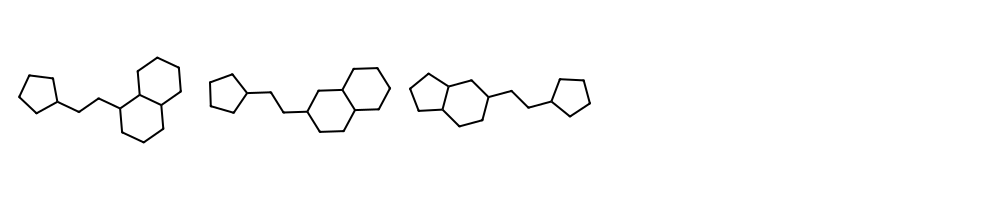

In [16]:
Draw.MolsToGridImage(mols, useSVG=True, molsPerRow=5)

The most populated SCINS class describes a molecule with 1 chain and 1 chain assembly (the two carbons in the middle),
3 rings and 2 ring assemblies (the two fused rings are one ring assembly and the other one is the ring at the other end of the chain),
the final part is for the length of the chains - since there is only one chain, there is only non-zero term -> 3 (3 bonds in the chain)

What are the scaffolds?

In [17]:
mols = [Chem.MolFromSmiles(smi) for smi in df_1803423[df_1803423['SCINS'] == '1_1_3_2_0-1_1_0_0-3_0_0_0']['scaffold'].unique()]

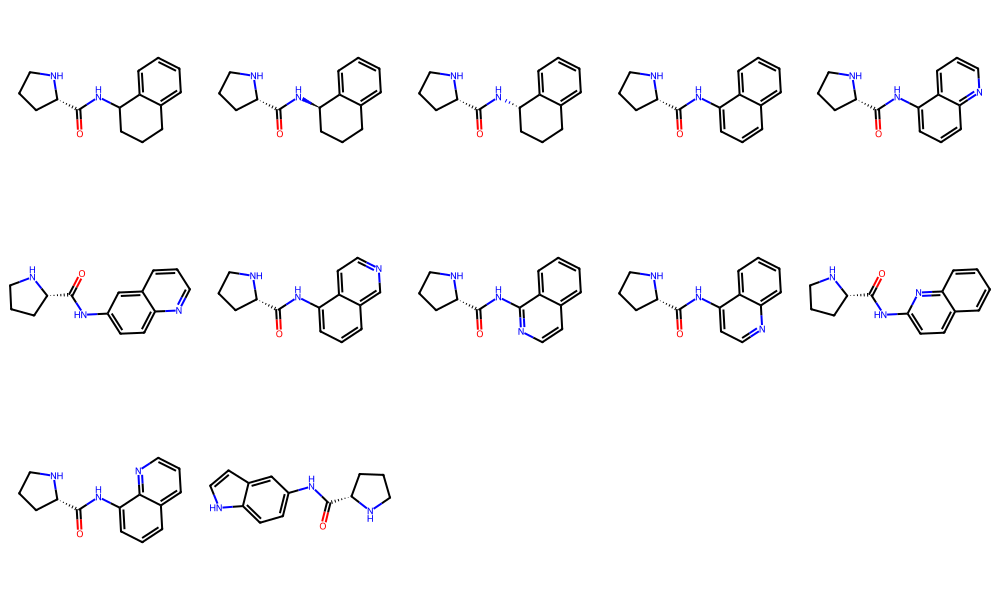

In [18]:
Draw.MolsToGridImage(mols, useSVG=True, molsPerRow=5)

I would say pretty sensible grouping by SCINS. In the second most populated SCINS class 

In [19]:
mols = [Chem.MolFromSmiles(smi) for smi in df_1803423[df_1803423['SCINS'] == '1_3_3_3_0-3_0_0_0-1_1_3_0']['scaffold'].unique()]

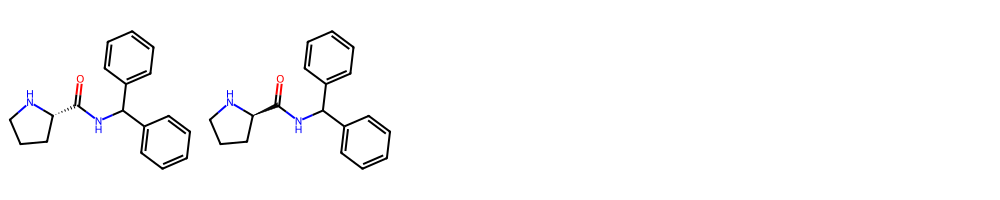

In [20]:
Draw.MolsToGridImage(mols, useSVG=True, molsPerRow=5)

The scaffolds are 2 because of chirality but otherwise I would say it is relatively sensible for these two to be considered a separate class (and hence the SCINS is grouping is sensible in this case).

Finally, I would like to illustratte the difference between the "sp2" generic Murcko (or the "classical" way) and the method I would use (especially to get SCINS which is supposed to be very coarse so no need to keep details like the carbonyl)

In [21]:
df_1803423['generic_scaffold_classical'].value_counts()

generic_scaffold_classical
CC(CC1CCCC2CCCCC21)C1CCCC1                       11
CC(CC(C1CCCCC1)C1CCCCC1)C1CCCC1                   9
CC(CCC1CCCCC1)C1CCCC1                             5
CC(CC1CCC2CCCCC2C1)C1CCCC1                        3
CC(CC1CCCCC1)C1CCCC1C(C)CC(C1CCCCC1)C1CCCCC1      2
CC(CCC1CCCCC1)C1CCCC1C(C)CC(C1CCCCC1)C1CCCCC1     1
CC(CC1CCC2CCCC2C1)C1CCCC1                         1
Name: count, dtype: int64

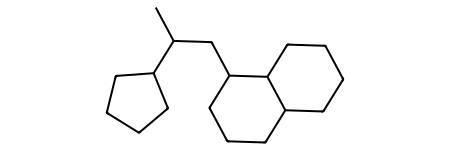

In [22]:
Chem.MolFromSmiles('CC(CC1CCCC2CCCCC21)C1CCCC1')

In [23]:
df_1803423['generic_scaffold'].value_counts()

generic_scaffold
C1CCC(CCC2CCCC3CCCCC32)C1                    11
C1CCC(C(CCC2CCCC2)C2CCCCC2)CC1                9
C1CCC(CCCC2CCCC2)CC1                          5
C1CCC(CCC2CCC3CCCCC3C2)C1                     3
C1CCC(CCC2CCCC2CCC(C2CCCCC2)C2CCCCC2)CC1      2
C1CCC(CCCC2CCCC2CCC(C2CCCCC2)C2CCCCC2)CC1     1
C1CCC(CCC2CCC3CCCC3C2)C1                      1
Name: count, dtype: int64

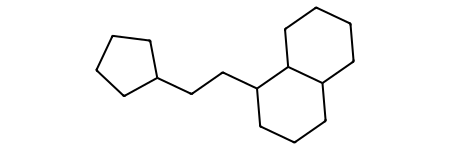

In [24]:
Chem.MolFromSmiles('C1CCC(CCC2CCCC3CCCCC32)C1')

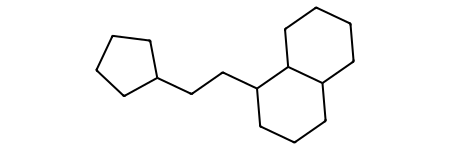

In [25]:
Chem.MolFromSmiles(get_gen_scaffold_for_smi_without_sp2('CN[C@@H](C)C(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1cccc2ccccc12)C(C)C'))

In this case all of the molecules have a carbonyl so the two methods give the same number of generic scaffolds.

### Data from the different assays

In [26]:
accum = []
dfs = {}
for aid in df_all_assays['chembl_id'].unique():
    query_aid = f"""
    select distinct(canonical_smiles), cids.chembl_id
        from activities 
            join assays on activities.assay_id=assays.assay_id
            join compound_structures on compound_structures.molregno=activities.molregno
            join chembl_id_lookup cids on activities.molregno=cids.entity_id and cids.entity_type='COMPOUND'
        where assays.chembl_id='{aid}'
          and standard_type='Ki'    
    """
    df_tmp = pd.read_sql(query_aid, con)
    df_tmp['scaffold'] = df_tmp['canonical_smiles'].apply(get_scaffold_for_smi)
    df_tmp['generic_scaffold_sp2'] = df_tmp['canonical_smiles'].apply(get_gen_scaffold_for_smi_with_sp2)
    df_tmp['generic_scaffold'] = df_tmp['canonical_smiles'].apply(get_gen_scaffold_for_smi_without_sp2)
    df_tmp['SCINS'] = df_tmp['generic_scaffold'].apply(get_scins_for_gen_scaffold_smi)
    dfs[aid] = df_tmp
    accum.append((aid,
                  df_tmp['canonical_smiles'].nunique(),
                  df_tmp['scaffold'].nunique(),
                  df_tmp['generic_scaffold_sp2'].nunique(),
                  df_tmp['generic_scaffold'].nunique(),
                  # exclude the cases where error scins was produced
                  df_tmp[df_tmp['SCINS']!=scins.ERROR_SCINS]['SCINS'].nunique()))
    if not len(accum)%1000:
        print(f'Done {len(accum)} of {df_all_assays.chembl_id.nunique()}')

Done 1000 of 7186
Done 2000 of 7186
Done 3000 of 7186
Done 4000 of 7186
Done 5000 of 7186
Done 6000 of 7186
Done 7000 of 7186


In [27]:
aids, num_mols, num_scaffs, num_gen_sp2_scaff, num_gen_scaff, num_scins = list(zip(*accum))

## Summary histograms of the fraction of scafolds and SCINS per molecule in the assays. 

### Murcko scaffolds

Text(0.5, 0, '$num_{scaffolds} / num_{compounds}$')

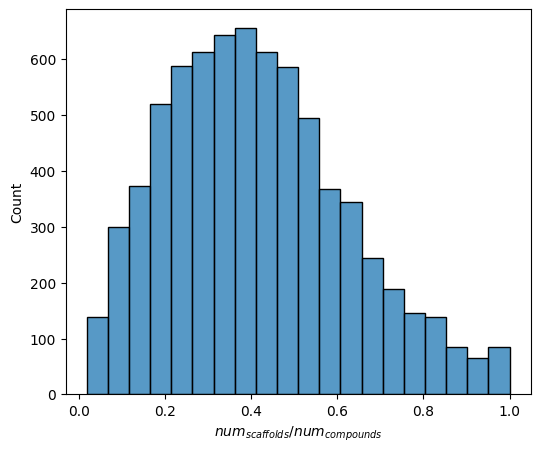

In [28]:
plt.figure(figsize=(6,5))
sns.histplot(x=np.asarray(num_scaffs) / np.asarray(num_mols),bins=20)
plt.xlabel('$num_{scaffolds} / num_{compounds}$')

In [29]:
print(f'mean: {np.mean(num_scaffs):.1f}, median: {np.median(num_scaffs):.1f}')

mean: 13.2, median: 12.0


In [30]:
print(f'mean: {np.mean(np.asarray(num_scaffs) / np.asarray(num_mols)):.2f}, median: {np.median(np.asarray(num_scaffs) / np.asarray(num_mols)):.2f}')

mean: 0.41, median: 0.39


Same as what Greg found. Let's see generic scaffolds and SCINS.

### Generic scaffolds with sp2

Text(0.5, 0, '$num_{GenericScaffolds} / num_{compounds}$')

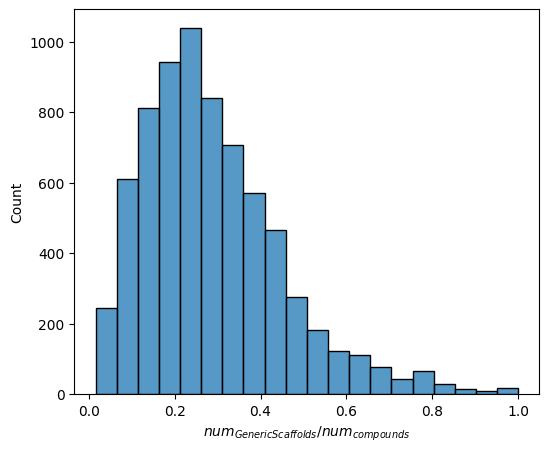

In [31]:
plt.figure(figsize=(6,5))
sns.histplot(x=np.asarray(num_gen_sp2_scaff) / np.asarray(num_mols),bins=20)
plt.xlabel('$num_{GenericScaffolds} / num_{compounds}$')

In [32]:
print(f'mean: {np.mean(num_gen_sp2_scaff):.1f}, median: {np.median(num_gen_sp2_scaff):.1f}')

mean: 9.1, median: 8.0


In [33]:
print(f'mean: {np.mean(np.asarray(num_gen_sp2_scaff) / np.asarray(num_mols)):.2f}, median: {np.median(np.asarray(num_gen_sp2_scaff) / np.asarray(num_mols)):.2f}')

mean: 0.29, median: 0.26


### Generic scaffolds without sp2

Text(0.5, 0, '$num_{GenericScaffolds} / num_{compounds}$')

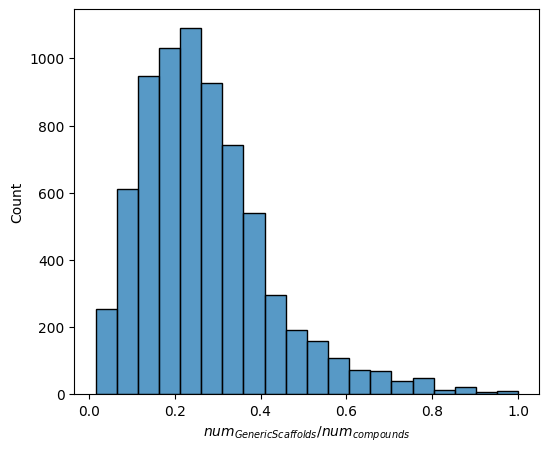

In [34]:
plt.figure(figsize=(6,5))
sns.histplot(x=np.asarray(num_gen_scaff) / np.asarray(num_mols),bins=20)
plt.xlabel('$num_{GenericScaffolds} / num_{compounds}$')

In [35]:
print(f'mean: {np.mean(num_gen_scaff):.1f}, median: {np.median(num_gen_scaff):.1f}')

mean: 8.6, median: 8.0


In [36]:
print(f'mean: {np.mean(np.asarray(num_gen_scaff) / np.asarray(num_mols)):.2f}, median: {np.median(np.asarray(num_gen_scaff) / np.asarray(num_mols)):.2f}')

mean: 0.27, median: 0.25


As expected the number of generic scaffolds w/o sp2 is lower than the number of scaffolds with sp2 (because w/o sp2 is slightly more abstracted).

### SCINS

Text(0.5, 0, '$num_{SCINS} / num_{compounds}$')

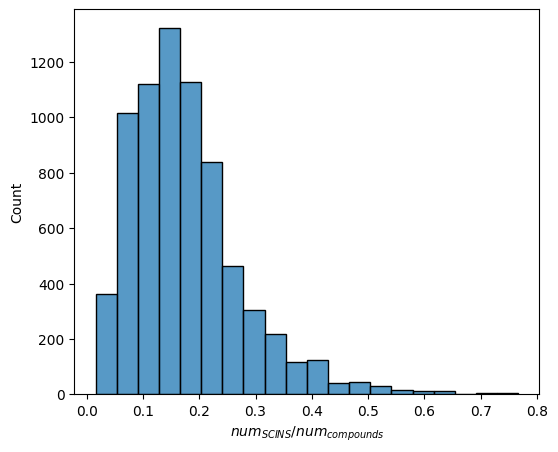

In [37]:
plt.figure(figsize=(6,5))
sns.histplot(x=np.asarray(num_scins) / np.asarray(num_mols),bins=20)
plt.xlabel('$num_{SCINS} / num_{compounds}$')

In [38]:
print(f'mean: {np.mean(num_scins):.1f}, median: {np.median(num_scins):.1f}')

mean: 5.4, median: 5.0


In [39]:
print(f'mean: {np.mean(np.asarray(num_scins) / np.asarray(num_mols)):.2f}, median: {np.median(np.asarray(num_scins) / np.asarray(num_mols)):.2f}')

mean: 0.18, median: 0.16


As expected the number of SCINS per assay is lower as this is the most abstracted representation.

### Finally use the manually extracted by Greg scaffolds to see in the most populated SCINS group more of the compounds in the assay, as would be expected.

In [40]:
acp = ['CHEMBL4049094', 'CHEMBL859243', 'CHEMBL4710796', 'CHEMBL3131699', 'CHEMBL4183750']

In [41]:
cmpd_accum = {}
for aid in acp:
    query = f"""
    select distinct(canonical_smiles), cids.chembl_id
        from activities 
            join assays on activities.assay_id=assays.assay_id
            join compound_structures on compound_structures.molregno=activities.molregno
            join chembl_id_lookup cids on activities.molregno=cids.entity_id and cids.entity_type='COMPOUND'
        where assays.chembl_id='{aid}'
          and standard_type='Ki'    
    """
    df_tmp = pd.read_sql(query, con)
    cmpd_accum[aid] = df_tmp['canonical_smiles'].values

In [42]:
# define the scaffolds in the same way as Greg in his blog post
scaffolds_from_papers = {
    'CHEMBL4049094':'*n1ncc(n1)C(=O)NC(C*)C(=O)NC1(CC1)C#N',
    'CHEMBL859243':'*CC(N1CCCC1)C(=O)c1ccccc1',
    'CHEMBL4710796':'*c1n[nH]c(=S)n1N=C-*',
    'CHEMBL3131699':'CC(C)(C)NC(=O)Nc1nc(Cl)c(*)n(C1=O)CC(=O)Nc1ccccc1C(=O)NS(=O)(=O)*',
    'CHEMBL4183750':'*C(=O)c1ccc(cc1)c1c(OC)ccc(c1)C1=NN(*)C(=O)C2C1CC=CC2'
}
ps = Chem.AdjustQueryParameters.NoAdjustments()
ps.makeDummiesQueries = True
for k in scaffolds_from_papers:
    scaffolds_from_papers[k] = Chem.AdjustQueryProperties(Chem.MolFromSmiles(scaffolds_from_papers[k]),ps)

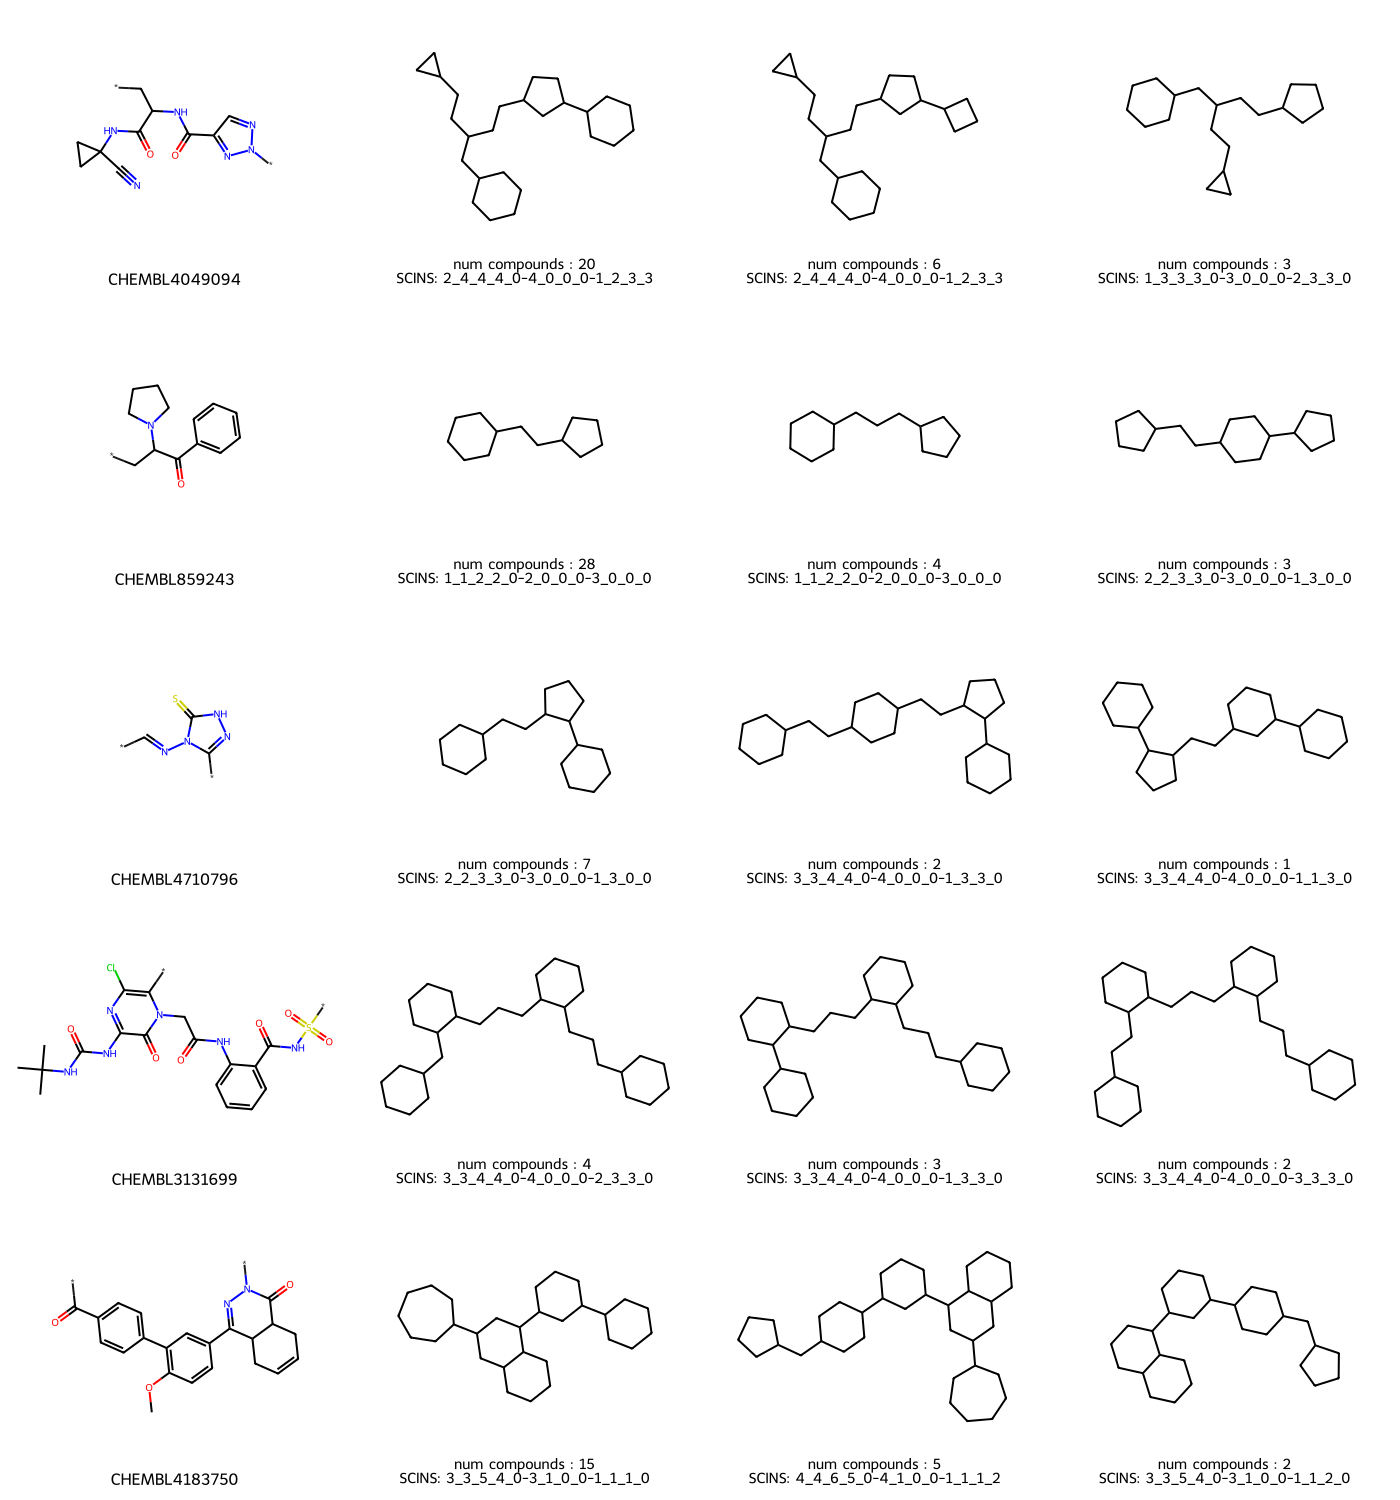

In [43]:
from collections import Counter
rows = []
labels = []
for k in scaffolds_from_papers:
    scins_descriptors = {}
    gen_scaffolds_no_sp2 = {}
    count_scins = Counter()
    count_gen_scaffolds_no_sp2 = Counter()
    gen_scaffolds_no_sp2_to_scins = {}
    for smi in cmpd_accum[k]:
        gen_scaff = get_gen_scaffold_for_smi_without_sp2(smi)
        count_gen_scaffolds_no_sp2[gen_scaff] += 1
        gen_scaffolds_no_sp2[gen_scaff] = Chem.MolFromSmiles(gen_scaff)

        gen_scaffolds_no_sp2_to_scins[gen_scaff] = get_scins_for_gen_scaffold_smi(gen_scaff)
        # scins_desc = get_scins_for_gen_scaffold_smi(gen_scaff)
        # count_scins[smi] += 1
        # scins_descriptors[smi] = scins_desc
    row = [scaffolds_from_papers[k]]
    lrow = [k]
    # top_scins = count_scins.most_common(3)
    top_gen_scaffolds_no_sp2 = count_gen_scaffolds_no_sp2.most_common(3)
    for smi,cnt in top_gen_scaffolds_no_sp2:
        row.append(gen_scaffolds_no_sp2[smi])
        lrow.append("num compounds : "+ str(cnt)+'\nSCINS: '+gen_scaffolds_no_sp2_to_scins[smi])
    rows.extend(row)
    labels.extend(lrow)
Draw.MolsToGridImage(rows,
                     legends=labels,
                     molsPerRow=4,
                     subImgSize=(350,300))

As can be seen in some cases the same SCINS described different gen scaffolds but in other cases was not sufficiently asbtracted. However, the different parts of the SICNS string can be used to judge the similarity of the gen scaffolds.

### How many compounds are in the most populated SCINS vs the num compounds that match  the manual scaffold?

SCINS is not supposed to be a series defining method, but out of curiosity.

In [44]:
for k in scaffolds_from_papers:
    # from Greg's blog
    nMatches = len([1 for smi in cmpd_accum[k] if Chem.MolFromSmiles(smi).HasSubstructMatch(scaffolds_from_papers[k])])
    scins_in_assay = [get_scins_for_gen_scaffold_smi(get_gen_scaffold_for_smi_without_sp2(smi)) for smi in cmpd_accum[k]]
    scins_counter = Counter(scins_in_assay)
    top_scins, num_mems =  scins_counter.most_common(1)[0]
    print(f'assay {k}:  num compounds={len(cmpd_accum[k])} num matching scaffold={nMatches}')
    print(f'assay {k}:  Most populated SCINS={top_scins} num members={num_mems}')

assay CHEMBL4049094:  num compounds=34 num matching scaffold=34
assay CHEMBL4049094:  Most populated SCINS=2_4_4_4_0-4_0_0_0-1_2_3_3 num members=27
assay CHEMBL859243:  num compounds=39 num matching scaffold=31
assay CHEMBL859243:  Most populated SCINS=1_1_2_2_0-2_0_0_0-3_0_0_0 num members=33
assay CHEMBL4710796:  num compounds=23 num matching scaffold=22
assay CHEMBL4710796:  Most populated SCINS=2_2_3_3_0-3_0_0_0-1_3_0_0 num members=7
assay CHEMBL3131699:  num compounds=28 num matching scaffold=22
assay CHEMBL3131699:  Most populated SCINS=3_3_4_4_0-4_0_0_0-2_3_3_0 num members=4
assay CHEMBL4183750:  num compounds=25 num matching scaffold=21
assay CHEMBL4183750:  Most populated SCINS=3_3_5_4_0-3_1_0_0-1_1_1_0 num members=15


In the case of CHEMBL859243 SCINS even matched more than the manually extracted scaffold. However, in the cases of CHEMBL4710796, CHEMBL3131699 performed pretty poorly, probably due to the general limitations of any scaffold method downstream of Murcko scaffolds - they more or less change upon adding/removing ring systems and atoms in the chains connecting the rings.

Since SCINS is a very abstracted descriptor of the generic scaffold, it might be better to use that for a scaffold split rather than Murcko scaffold (so a "SCINS" split). Also, the different descriptors in SCINS can be used to judge the similarity between different SCINS which could be an additional metric to judge the similarity between compounds with one SCINS in the training set and those with a different SCINS in the val/test set.